In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Extract Data

In [2]:
from bs4 import BeautifulSoup 
entries = []
entry = []
urlnumber = 2
while urlnumber < 105: 
    url = 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p%d' % (urlnumber,)
    try:
        r = requests.get(url, timeout = 10) 
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml')
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): 
            ps = div.find_all('p') 
            aas = div.find_all('a')
            spans = div.find_all('span')
            times = div.find_all('time') 
            concat_str = ''
            for str in aas[1].contents: 
                if str != "<br>" or str != "<br/>": 
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip()
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): 
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) 
                        bl.decompose()
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

print ("Wrote to edmunds_extraction.csv")

Wrote to edmunds_extraction.csv


In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('/Users/kushagra/Documents/McGill_Term_3/Text Analytics/edmunds_extraction.csv',header=None)

In [4]:
df.columns=['userid','date','message']

In [5]:
df

,userid,date,message
0,elroy5,April 2007,"No, I have not driven a Sonata. I have driven..."
1,plekto,April 2007,Of course the Buick LaCrosse qualifies. It ce...
2,punkr77,April 2007,One thing that drops the Maxima off my shoppi...
3,backy,April 2007,Good point. Another way Nissan differentiates...
4,lilengineerboy,April 2007,"Elroy,Autocross is typically a ""course"" confi..."
...,...,...,...
5145,urnews,September 2007,"That is one bad (as in good) looking Camry, e..."
5146,tlong,September 2007,2. The majority of G6s I see are not rentals....
5147,elroy5,September 2007,"And what if someone likes car B better, shoul..."
5148,thegraduate,September 2007,Question for the audience: Which manufacturer...


### Brands and models from external source plus file provided
- We have combined the file provided and the external file taken from kaggle in this code
- Sometimes there is comma and special characters in the brand and models

In [6]:
df_brands=pd.read_csv('brands.csv')
df_models=pd.read_csv('model.csv')
df_brand_model=pd.merge(df_models,df_brands,left_on='brand_id',right_on='id')
df_brand_model=df_brand_model[['name_x','name_y']].rename(columns={'name_x':'Model','name_y':'Brand'})
df_brand_model_given=pd.read_csv('models.csv',header=None).rename(columns={0:'Brand',1:'Model'})
df_brand_model['Model']=df_brand_model['Model'].apply(lambda x:x.lower())
df_brand_model['Brand']=df_brand_model['Brand'].apply(lambda x:x.lower())
df_brand_model_given['Model']=df_brand_model_given['Model'].apply(lambda x:x.lower())
df_brand_model_given['Brand']=df_brand_model_given['Brand'].apply(lambda x:x.lower())
df_brand_model_final=df_brand_model_given.append(df_brand_model).drop_duplicates()
df_brand_model=df_brand_model_final.reset_index().drop(columns='index')
df_brand_model

,Brand,Model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx
...,...,...
1029,volvo,c30
1030,volvo,s40
1031,volvo,s70
1032,volvo,v50


In [63]:
df_brand_model['Brand']=df_brand_model['Brand'].str.replace(',','')
df_brand_model['Model']=df_brand_model['Model'].str.replace('.','')
df_brand_model['Brand']=df_brand_model['Brand'].str.replace('.','')
df_brand_model['Model']=df_brand_model['Model'].str.replace(',','')
df_brand_model['Brand']=df_brand_model['Brand'].apply(lambda x:x.strip())
df_brand_model['Model']=df_brand_model['Model'].apply(lambda x:x.strip())

  
We saw that in few of the brands values like car, sedan, problem and seat were there in the dataframe. We dropped those rows as they have no significance and can manipulate the results

In [7]:
df_brand_model=df_brand_model[(df_brand_model['Brand']!='car') & (df_brand_model['Brand']!='sedan') & (df_brand_model['Brand']!='problem') & (df_brand_model['Brand']!='seat')]


In [8]:
df['message']=df['message'].astype('str')

### Stopwords removal

In [9]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df)

              userid            date  \
0             elroy5      April 2007   
1             plekto      April 2007   
2            punkr77      April 2007   
3              backy      April 2007   
4     lilengineerboy      April 2007   
...              ...             ...   
5145          urnews  September 2007   
5146           tlong  September 2007   
5147          elroy5  September 2007   
5148     thegraduate  September 2007   
5149         m1miata  September 2007   

                                                message  
0     No, I driven Sonata. I driven Camrys, I've hea...  
1     Of course Buick LaCrosse qualifies. It certain...  
2     One thing drops Maxima shopping list (but matt...  
3     Good point. Another way Nissan differentiates ...  
4     Elroy,Autocross typically "course" configured ...  
...                                                 ...  
5145  That one bad (as good) looking Camry, even tho...  
5146  2. The majority G6s I see rentals. You easily ...

### Tokenization

In [10]:
import nltk
from nltk.tokenize import word_tokenize
df['message']=df['message'].apply(lambda x:word_tokenize(x))

In [11]:
temp=pd.DataFrame()
temp['message']=df['message']

### Tagging words with pos_tag and lemmatization
- Extracted only the nouns from pos tag as brands and models will come under them
- Didn't use porter stemmer as it can manipulate the brand names

In [12]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df['message']=df['message'].apply(lambda x:nltk.pos_tag(x))
print(df['message'])
for l in range(len(df['message'])):
    df['message'].iloc[l]=[j[0] for j in df['message'].iloc[l] if j[1].startswith("NN") or j[1].startswith("VB")]

0       [(No, DT), (,, ,), (I, PRP), (driven, VBP), (S...
1       [(Of, IN), (course, NN), (Buick, NNP), (LaCros...
2       [(One, CD), (thing, NN), (drops, VBZ), (Maxima...
3       [(Good, JJ), (point, NN), (., .), (Another, DT...
4       [(Elroy, NNP), (,, ,), (Autocross, NNP), (typi...
                              ...                        
5145    [(That, DT), (one, CD), (bad, JJ), ((, (), (as...
5146    [(2, CD), (., .), (The, DT), (majority, NN), (...
5147    [(And, CC), (someone, NN), (likes, NNS), (car,...
5148    [(Question, NN), (audience, NN), (:, :), (Whic...
5149    [(Look, NNP), (OK, NNP), (,, ,), (somewhat, RB...
Name: message, Length: 5150, dtype: object


In [14]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w).lower() for w in text]
df['message']=df['message'].apply(lambda x:lemmatize_text(x))

from nltk.stem import PorterStemmer
ps = PorterStemmer()
def porter_stemmer(text):
    return [ps.stem(w).lower() for w in text]
#df['message'].apply(lambda x:porter_stemmer(x))

### Replacing any model that comes in the line with the brand

In [18]:
for i in range(len(df['message'])):
    for j in range(len(df_brand_model)):
        if(df_brand_model['Model'].iloc[j] in df['message'].iloc[i]):
            #print(df_brand_model['Model'].iloc[j])
            idx=df['message'].iloc[i].index(df_brand_model['Model'].iloc[j])
            df['message'].iloc[i][idx]=df_brand_model['Brand'].iloc[j]

   
<br>
Creating empty column for each brand to populate the brands

In [20]:
import numpy as np
for brand in set(df_brand_model['Brand']):
    df[brand]=np.nan

In [21]:
df

,userid,date,message,chrysler,tata,skoda,daihatsu,chevrolet,geely,rover,...,dodge,pontiac,ferrari,proton,lincoln,isuzu,land rover,alfa romeo,renault,lancia
0,elroy5,April 2007,"[driven, hyundai, driven, toyota, 've, heard, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,plekto,April 2007,"[course, buick, buick, qualifies, luxury, car,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,punkr77,April 2007,"[thing, drop, nissan, shopping, list, %, buyer...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,backy,April 2007,"[point, way, nissan, differentiates, nissan, n...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lilengineerboy,April 2007,"[elroy, autocross, course, configured, bunch, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,urnews,September 2007,"[good, looking, toyota, buy, toyota]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5146,tlong,September 2007,"[majority, g6s, see, rental, tell, rental, loo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5147,elroy5,September 2007,"[someone, like, car, b, better, frightened, ba...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5148,thegraduate,September 2007,"[question, audience, manufacturer, dominates, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for brand in set(df_brand_model['Brand']):
    for j in range(len(df['message'])):
        if(brand in df['message'].iloc[j]):
            df[brand].iloc[j]=1
        else:
            df[brand].iloc[j]=0

### Top 10 brands by frequency

In [24]:
df_top_ten_brands=pd.DataFrame(df.iloc[:, 3:].sum(axis=0)).reset_index()
df_top_ten_brands.columns=['brand','frequency']
df_top_ten_brands=df_top_ten_brands.sort_values(by='frequency',ascending=False).reset_index().drop(columns=['index'])

In [25]:
cols_imp=list(df_top_ten_brands['brand'])

In [26]:
cols_imp=cols_imp[0:10]

In [27]:
df[cols_imp].sum()

honda        2152.0
ford         1373.0
toyota       1044.0
hyundai       631.0
nissan        631.0
mazda         553.0
chevrolet     282.0
chrysler      275.0
saturn        253.0
subaru        157.0
dtype: float64

### Lift Similarity of top 10 brands

In [28]:
df_1=df[cols_imp]

df_1=df_1.reset_index().drop(columns='index')
idx=0
for i in range(len(df_1.columns)):
    for j in range(i+1,len(df_1.columns)):
        print(i,j,df_1.columns[i],df_1.columns[j],len(df_1[(df_1[df_1.columns[i]]==1) & (df_1[df_1.columns[j]]==1)])*len(df_1)/(len(df_1[(df_1[df_1.columns[i]]==1)])*len(df_1[(df_1[df_1.columns[j]]==1)])))
        df_1[df_1.columns[j]].iloc[idx]=len(df_1[(df_1[df_1.columns[i]]==1) & (df_1[df_1.columns[j]]==1)])*len(df_1)/(len(df_1[(df_1[df_1.columns[i]]==1)])*len(df_1[(df_1[df_1.columns[j]]==1)]))
    idx=idx+1

0 1 honda ford 1.1608300820118211
0 2 honda toyota 1.6779365893261549
0 3 honda hyundai 1.475316515355929
0 4 honda nissan 1.4108425288236646
0 5 honda mazda 1.1814149922356596
0 6 honda chevrolet 1.315368847056342
0 7 honda chrysler 1.3749577559986481
0 8 honda saturn 1.2864216759481024
0 9 honda subaru 1.3566109440484928
1 2 ford toyota 1.3629866225710334
1 3 ford hyundai 1.2145805153816807
1 4 ford nissan 1.2086266893258881
1 5 ford mazda 1.1937798066297978
1 6 ford chevrolet 1.3700133785829034
1 7 ford chrysler 1.377607097927564
1 8 ford saturn 1.3787931565568603
1 9 ford subaru 0.788407921655587
2 3 toyota hyundai 1.8653456908490464
2 4 toyota nissan 2.080262542165424
2 5 toyota mazda 0.9286052370145238
2 6 toyota chevrolet 2.153668835805063
2 7 toyota chrysler 1.2209535431011942
2 8 toyota saturn 2.302949457895475
2 9 toyota subaru 1.1951072054521805
3 4 hyundai nissan 1.6531442725710241
3 5 hyundai mazda 1.1234536008496225
3 6 hyundai chevrolet 1.623325453112687
3 7 hyundai chry

In [29]:
df_1=df_1[:len(df_1.columns)]
cols=df_1.columns

df_1.index=cols
df_1.columns=cols

for i in range(len(df_1.columns)):
    for j in range(len(df_1.columns)):
        if(i==j):
            df_1[df_1.columns[i]][j]=0
        elif(i<j):
            df_1[df_1.columns[i]][j]=df_1[df_1.columns[j]][i]

In [32]:
df_1

,honda,ford,toyota,hyundai,nissan,mazda,chevrolet,chrysler,saturn,subaru
honda,0.000000,1.160830,1.677937,1.475317,1.410843,1.181415,1.315369,1.374958,1.286422,1.356611
ford,1.160830,0.000000,1.362987,1.214581,1.208627,1.193780,1.370013,1.377607,1.378793,0.788408
toyota,1.677937,1.362987,0.000000,1.865346,2.080263,0.928605,2.153669,1.220954,2.302949,1.195107
hyundai,1.475317,1.214581,1.865346,0.000000,1.653144,1.123454,1.623325,1.486291,1.874020,1.978566
nissan,1.410843,1.208627,2.080263,1.653144,0.000000,1.529860,1.951486,1.105118,2.759549,2.092667
mazda,1.181415,1.193780,0.928605,1.123454,1.529860,0.000000,0.891655,0.677297,0.993860,3.084507
chevrolet,1.315369,1.370013,2.153669,1.623325,1.951486,0.891655,0.000000,1.866063,5.577905,1.400821
chrysler,1.374958,1.377607,1.220954,1.486291,1.105118,0.677297,1.866063,0.000000,0.962271,0.834974
saturn,1.286422,1.378793,2.302949,1.874020,2.759549,0.993860,5.577905,0.962271,0.000000,1.685506
subaru,1.356611,0.788408,1.195107,1.978566,2.092667,3.084507,1.400821,0.834974,1.685506,0.000000


In [33]:
df_1.to_excel('lift_similarity.xlsx')

### 1/Lift(dissimilarity)

In [34]:
df_2=pd.DataFrame()
for l in df_1.columns:
    df_2[l]=np.nan
    df_2[l]=df_1[l].astype('int')
    df_2[l]=1/df_1[l]

In [35]:
df_2.columns

Index(['honda', 'ford', 'toyota', 'hyundai', 'nissan', 'mazda', 'chevrolet',
       'chrysler', 'saturn', 'subaru'],
      dtype='object')

In [36]:
df_2

,honda,ford,toyota,hyundai,nissan,mazda,chevrolet,chrysler,saturn,subaru
honda,inf,0.861453,0.595970,0.677821,0.708796,0.846443,0.760243,0.727295,0.777350,0.737131
ford,0.861453,inf,0.733683,0.823330,0.827385,0.837675,0.729920,0.725896,0.725272,1.268379
toyota,0.595970,0.733683,inf,0.536094,0.480709,1.076884,0.464324,0.819032,0.434226,0.836745
hyundai,0.677821,0.823330,0.536094,inf,0.604908,0.890112,0.616019,0.672816,0.533612,0.505416
nissan,0.708796,0.827385,0.480709,0.604908,inf,0.653654,0.512430,0.904881,0.362378,0.477859
mazda,0.846443,0.837675,1.076884,0.890112,0.653654,inf,1.121510,1.476456,1.006178,0.324201
chevrolet,0.760243,0.729920,0.464324,0.616019,0.512430,1.121510,inf,0.535888,0.179279,0.713867
chrysler,0.727295,0.725896,0.819032,0.672816,0.904881,1.476456,0.535888,inf,1.039208,1.197642
saturn,0.777350,0.725272,0.434226,0.533612,0.362378,1.006178,0.179279,1.039208,inf,0.593294
subaru,0.737131,1.268379,0.836745,0.505416,0.477859,0.324201,0.713867,1.197642,0.593294,inf


In [37]:
df_2.to_excel('lift_dissimilarity.xlsx')

### MDS Plot

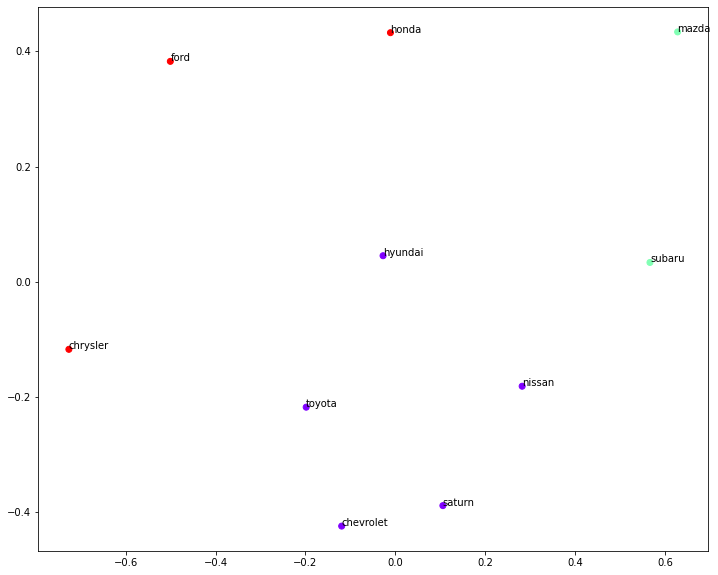

In [38]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

column_names=list(df_2.columns)

for i in range(len(df_2.columns)):
    for j in range(len(df_2.columns)):
        if(i==j):
            df_2[df_2.columns[i]][j]=0
mds = MDS(n_components=2,dissimilarity='precomputed',random_state=0)
X_2d = mds.fit_transform(df_2)
df_2.to_excel('~/Downloads/hh.xlsx')
car_brand_plot = pd.DataFrame(X_2d, columns = ['x','y'])
car_brand_plot['brands'] = column_names

X = car_brand_plot[['x','y']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=10)
model = kmeans.fit(X_std)
labels = model.predict(X_std)# Plot cluster membership
from matplotlib import pyplot
plt.figure(figsize=(12,10))
pyplot.scatter(car_brand_plot['x'], car_brand_plot['y'], c=labels, cmap='rainbow')
for i, label in enumerate(car_brand_plot['brands']):
    pyplot.annotate(label, (car_brand_plot['x'][i], car_brand_plot['y'][i]))

In [39]:
all_messages=df['message']
all_words=set()
for words_list in all_messages:
    all_words.update(words_list)
brand_names=set(df_brand_model['Brand'])
all_words.difference(brand_names)
frequency_dictionary={}
for word in all_words:
    count=0
    for word_list in all_messages:
        if word in word_list:
            count+=word_list.count(word)
    frequency_dictionary[word]=count
top_occurences=sorted(frequency_dictionary.items(), key=lambda x: x[1], reverse=True)[:70]
print(top_occurences)
top_attributes=['engine','price','people','sale','value','power','cost','dealer','mileage','mpg','warranty',
               'awd','hp','reliability','quality','gas','wheel','look','transmission','money','brand','performance',
               'fuel','control']

[('car', 5232), ('honda', 3487), ('ford', 2503), ('year', 1598), ('toyota', 1466), ('think', 1461), ('get', 1461), ('accord', 1256), ('v6', 1105), ("'s", 1081), ('engine', 1063), ('time', 1046), ('hyundai', 940), ('make', 918), ('mazda', 824), ('nissan', 820), ('thing', 812), ('look', 809), ('know', 796), ('see', 789), ('mile', 787), ("'m", 782), ('price', 761), ('say', 750), ('vehicle', 731), ('people', 727), ('way', 703), ('model', 702), ('sale', 674), ('fusion', 673), ('go', 643), ('going', 607), ('cost', 576), ('buy', 569), ('value', 569), ('sedan', 556), ('drive', 553), ("'ve", 548), ('something', 538), ('lot', 535), ('want', 527), ('driving', 504), ('need', 499), ('problem', 481), ('power', 473), ('take', 461), ('%', 451), ('difference', 437), ('gm', 435), ('got', 434), ('number', 431), ('dealer', 422), ('point', 408), ('said', 408), ('come', 406), ('chevrolet', 400), ('class', 396), ('mileage', 388), ('mpg', 385), ('is', 382), ('used', 380), ('camry', 371), ('sell', 365), ('do',

Group relevant features under different defined attributes:

- Performance: 'engine','power','mileage','mpg','hp', 'gas', 'wheel', 'transmission', 'performance', 'fuel'

- Reliability: 'reliability','quality', 'control'

- Brand Image and Visibility:'people','dealer', 'look', 'brand'

- Price: 'price','sale','value','cost', 'money'

- Special Features: 'warranty', 'awd'

In [40]:
# Forming dictionary to bin different features and attributes together

attribute_dict={'Performance': [ 'engine','power','mileage','mpg','hp', 'gas', 'wheel', 'transmission', 'performance', 'fuel'], 
                'Reliability':['reliability','quality', 'control'],
               'Brand Image':['people','dealer', 'look', 'brand'], 'Price':['price','sale','value','cost', 'money'],
                'Special Features':['warranty', 'awd']}

In [41]:
attributes= list(attribute_dict.keys())

In [42]:
for attribute in attributes:
    for word in attribute_dict[attribute]:
        for i in range(len(df.index)):
            for j in range(len(df['message'].iloc[i])):
                if word==df.loc[i,'message'][j]:
                    df.loc[i,'message'][j]=attribute           

In [43]:
document_representation=[]
for comment in df['message']:
    document_representation.append([comment.count('Performance'), comment.count('Reliability'), 
                                    comment.count('Brand Image'), comment.count('Price'), 
                                    comment.count('Special Features')])
document_representation = pd.DataFrame(document_representation,
                                       columns=['Performance', 'Reliability', 'Brand Image', 
                                                'Price', 'Special Features'])

In [44]:
comment_number=[]
for i in range(len(df.index)):
    comment_number.append(i+1)
comment_number=pd.DataFrame(comment_number,columns=['Comment_Number'])
document_representation['Comment_number']=document_representation.index+1

In [45]:
document_representation

,Performance,Reliability,Brand Image,Price,Special Features,Comment_number
0,0,0,0,0,0,1
1,0,0,0,0,0,2
2,0,0,0,0,0,3
3,0,0,0,0,0,4
4,1,1,0,0,0,5
...,...,...,...,...,...,...
5145,0,0,0,0,0,5146
5146,1,0,0,0,0,5147
5147,0,0,0,0,0,5148
5148,0,0,0,2,0,5149


5 0 honda Performance 1.0222052575677112
5 1 honda Reliability 1.2824159267673911
5 2 honda Brand Image 1.1957800581254918
5 3 honda Price 1.242737082223774
5 4 honda Special Features 1.2799949933841148
6 0 ford Performance 1.1038393507439392
6 1 ford Reliability 1.26259146652446
6 2 ford Brand Image 1.0896499530042683
6 3 ford Price 1.0892919865282484
6 4 ford Special Features 1.6302033727379686
7 0 toyota Performance 1.1486726874657909
7 1 toyota Reliability 1.2362676155779604
7 2 toyota Brand Image 1.234615466940645
7 3 toyota Price 1.4001540622592776
7 4 toyota Special Features 1.4798850574712643
8 0 hyundai Performance 0.9560787865066788
8 1 hyundai Reliability 0.9023935331383826
8 2 hyundai Brand Image 1.176371636756412
8 3 hyundai Price 1.2011886936656455
8 4 hyundai Special Features 1.2870291356820676
9 0 nissan Performance 1.1426307448494453
9 1 nissan Reliability 1.2452712452712453
9 2 nissan Brand Image 1.1417043539948568
9 3 nissan Price 1.235321110485368
9 4 nissan Special

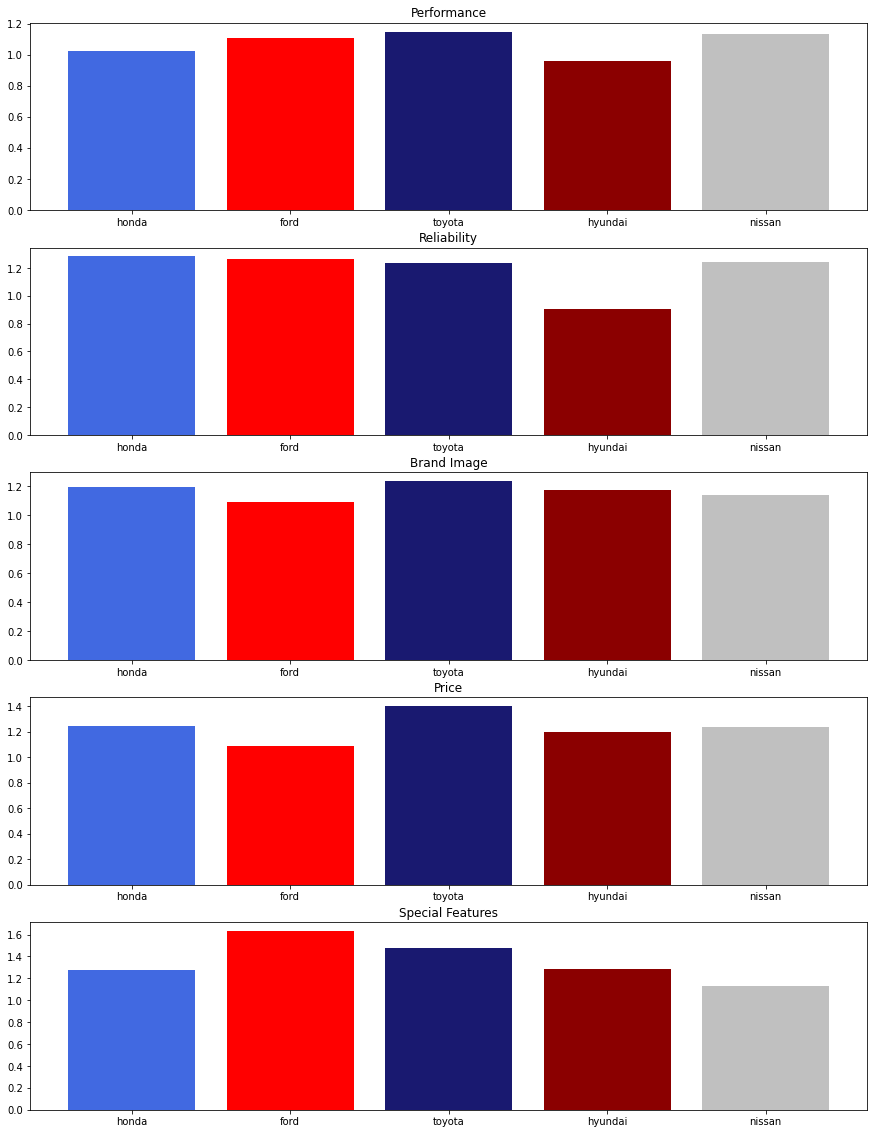

In [46]:
document_representation = document_representation[['Comment_number','Performance', 'Reliability', 
                                                   'Brand Image', 'Price', 'Special Features']]

document_representation

top_five_brands=['honda',
                 'ford',
                 'toyota',
                 'hyundai',
                 'nissan']

attributes_and_brands = list(attribute_dict.keys()) 
for element in top_five_brands:
    attributes_and_brands.append(element)
    
co_mentions=[]

for comment in df['message']:
    co_mentions.append([comment.count(element) for element in attributes_and_brands])

co_mentions = pd.DataFrame(co_mentions, columns=attributes_and_brands)

for brand in top_five_brands:
    for row in range(len(co_mentions)):
        if co_mentions[brand][row]>=1:
            co_mentions[brand][row]=1
    

idx=0

perf_brand =[]
reliab_brand =[]
image_brand =[]
price_brand =[]
feature_brand = []
for j in range(5,len(co_mentions.columns)):
    for i in range(len(co_mentions.columns[0:5])):
        print(j,i,co_mentions.columns[j],co_mentions.columns[i],
              len(co_mentions[(co_mentions[co_mentions.columns[i]]==1) & (co_mentions[co_mentions.columns[j]]==1)])
              *len(co_mentions)
              /
              (len(co_mentions[(co_mentions[co_mentions.columns[i]]==1)])
               *len(co_mentions[(co_mentions[co_mentions.columns[j]]==1)]))
             )
        co_mentions[co_mentions.columns[j]].iloc[idx]=len(co_mentions[(co_mentions[co_mentions.columns[i]]==1) & (co_mentions[co_mentions.columns[j]]==1)])*len(co_mentions)/(len(co_mentions[(co_mentions[co_mentions.columns[i]]==1)])*len(co_mentions[(co_mentions[co_mentions.columns[j]]==1)]))
        lift_value = len(co_mentions[(co_mentions[co_mentions.columns[i]]==1) & (co_mentions[co_mentions.columns[j]]==1)])*len(co_mentions)/(len(co_mentions[(co_mentions[co_mentions.columns[i]]==1)])*len(co_mentions[(co_mentions[co_mentions.columns[j]]==1)]))
        if co_mentions.columns[i] == "Performance":
            perf_brand.append(lift_value)
        elif co_mentions.columns[i] == "Reliability":
            reliab_brand.append(lift_value)
        elif co_mentions.columns[i] == "Brand Image":
            image_brand.append(lift_value)
        elif co_mentions.columns[i] == "Price":
            price_brand.append(lift_value)
        elif co_mentions.columns[i] == "Special Features":
            feature_brand.append(lift_value)
    idx=idx+1

df_brand_attributes = pd.DataFrame(columns=top_five_brands)
df_brand_attributes.loc[0] = perf_brand
df_brand_attributes.loc[1] = reliab_brand
df_brand_attributes.loc[2] = image_brand
df_brand_attributes.loc[3] = price_brand
df_brand_attributes.loc[4] = feature_brand
df_brand_attributes.index = co_mentions.columns[0:5]

for i in document_representation.columns:
    if i is not 'Comment_number':
        print(i,":",document_representation[i].sum())
        print(i,":", len(document_representation[(document_representation[i]>0)]),"(unique messages)")

import seaborn as sns
cm = sns.color_palette("blend:white,lightgreen,green", as_cmap=True)
df_brand_attributes.style.background_gradient(cmap=cm,axis=1)


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,20))
c = ['royalblue', 'red', 'midnightblue', 'darkred', 'silver']

for i, (name, row) in enumerate(df_brand_attributes.iterrows()):
    ax = plt.subplot(5,1, i+1)
    ax.set_title(row.name)
    #ax.set_aspect('equal')
    ax.bar(height=row, x=row.index, color=c)

plt.show()

### Aspiration

 

Tried wordnet to find synonyms for aspiration but a word can have multiple meanings like aspire means to breath and also to rise high other than hope or ambition. Because of these ambiguity in finding the correct synonyms, we hardcoded the synonyms of Aspiration and Aim

In [47]:
df_top_five=df[['userid','date','message','honda','ford','toyota','hyundai','nissan']]
from nltk.corpus import wordnet
list_hyponym=[]
list_aspire=['aim']
for aspire_param in list_aspire:
    for syn in wordnet.synsets(aspire_param):
        for l in syn.lemmas():
            if l.antonyms():
                continue
        list_hyponym.append(sorted([l.name()]))
list_aspirations=list(set([x for s in list_hyponym for x in s]))
converter = lambda x: x.replace('_',' ')
list_aspirations = list(map(converter, list_aspirations))

In [48]:
list_aspirations=['aspire','desire','goal','wish','fancy','afford','future','aim','dream','covet','crave','prefer','ike']

In [49]:
df['message']=temp['message']

<br>
Created empty columns for aspirations

In [51]:
for i in list_aspirations:
    df[i]=np.nan

In [52]:
df

,userid,date,message,chrysler,tata,skoda,daihatsu,chevrolet,geely,rover,...,wish,fancy,afford,future,aim,dream,covet,crave,prefer,ike
0,elroy5,April 2007,"[No, ,, I, driven, Sonata, ., I, driven, Camry...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,plekto,April 2007,"[Of, course, Buick, LaCrosse, qualifies, ., It...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,punkr77,April 2007,"[One, thing, drops, Maxima, shopping, list, (,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,backy,April 2007,"[Good, point, ., Another, way, Nissan, differe...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lilengineerboy,April 2007,"[Elroy, ,, Autocross, typically, ``, course, '...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,urnews,September 2007,"[That, one, bad, (, as, good, ), looking, Camr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5146,tlong,September 2007,"[2, ., The, majority, G6s, I, see, rentals, .,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5147,elroy5,September 2007,"[And, someone, likes, car, B, better, ,, frigh...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5148,thegraduate,September 2007,"[Question, audience, :, Which, manufacturer, d...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
len(df['message'].iloc[0])

111

In [54]:
brand=list(df_brand_model['Brand'].unique())

<br>
As a message can have multiple brands , if we need to check for direct correlation with a brand we need to check if the brand occurs just after the aspiration characteristic. We have a limited sized dataset because of which we couldn't find a lot of brands that we can correlate directly with aspiration.

In [258]:
for j in range(len(df['message'])):
    for i in list_aspirations:
        #print(j,i)
        if(i in df['message'].iloc[j]):
            idx=df['message'].iloc[j].index(i)
            if(idx<len(df['message'].iloc[j])-1):
                if(df['message'].iloc[j][idx+1] in brand):
                    print(j,i)
                    df[i].iloc[j]=df['message'].iloc[j][idx+1]
                else:
                    df[i].iloc[j]=0
            else:
                df[i].iloc[j]=0
        else:
            df[i].iloc[j]=0     

933 wish
1059 fancy
2502 aim
2787 desire
4877 afford


## Aspirational Brand
- Check lift values between aspiration and brand
- We have taken both aspiration and frequency as the indicators for aspirational brand

In [55]:

for i in list_aspirations:
    for j in range(len(df['message'])):
        if(i in df['message'].iloc[j]):
            df[i].iloc[j]=1
        else:
            df[i].iloc[j]=0

In [57]:
df

,userid,date,message,chrysler,tata,skoda,daihatsu,chevrolet,geely,rover,...,wish,fancy,afford,future,aim,dream,covet,crave,prefer,ike
0,elroy5,April 2007,"[No, ,, I, driven, Sonata, ., I, driven, Camry...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,plekto,April 2007,"[Of, course, Buick, LaCrosse, qualifies, ., It...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,punkr77,April 2007,"[One, thing, drops, Maxima, shopping, list, (,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,backy,April 2007,"[Good, point, ., Another, way, Nissan, differe...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,lilengineerboy,April 2007,"[Elroy, ,, Autocross, typically, ``, course, '...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,urnews,September 2007,"[That, one, bad, (, as, good, ), looking, Camr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,tlong,September 2007,"[2, ., The, majority, G6s, I, see, rentals, .,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,elroy5,September 2007,"[And, someone, likes, car, B, better, ,, frigh...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5148,thegraduate,September 2007,"[Question, audience, :, Which, manufacturer, d...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculating lift values for aspiration with brands

In [58]:
df['aspiration']=df.iloc[:,-len(list_aspirations):].sum(axis=1)
df['aspiration']=np.where(df['aspiration']==0,0,1)
df.groupby('aspiration').sum()
cols=df.columns
list_cols=list(cols[3:-len(list_aspirations)-1])
list_cols.append('aspiration')
df1=df[list_cols]
idx=0
for i in range(len(df_1.columns)):
    for j in range(len(df_1.columns)):
        
        if(df_1.columns[i]=='aspiration' and len(df_1[(df_1[df_1.columns[j]]==1)])>0):
            print(i,j,df_1.columns[i],df_1.columns[j],len(df_1[(df_1[df_1.columns[i]]==1) & (df_1[df_1.columns[j]]==1)])*len(df_1)/(len(df_1[(df_1[df_1.columns[i]]==1)])*len(df_1[(df_1[df_1.columns[j]]==1)])))
            df_1[df_1.columns[j]].iloc[idx]=len(df_1[(df_1[df_1.columns[i]]==1) & (df_1[df_1.columns[j]]==1)])*len(df_1)/(len(df_1[(df_1[df_1.columns[i]]==1)])*len(df_1[(df_1[df_1.columns[j]]==1)]))
    idx=idx+1
df_1=df_1[:len(df_1.columns)]
cols=df_1.columns
df_1.index=cols
df_1.columns=cols

In [195]:
df_1.tail(1).T['aspiration'].nlargest(10)[1:]

citroen    6.812169
dacia      6.812169
skoda      5.109127
opel       4.932950
daewoo     4.087302
renault    3.715729
isuzu      3.406085
mercury    3.184910
jeep       2.919501
Name: aspiration, dtype: float64

In [196]:
df_aspire=df_1.tail(1).T.sort_values(by='aspiration',ascending=False).reset_index().rename(columns={'index':'Brand'})[1:]
df_freq=pd.DataFrame(df[list(df_aspire['Brand'])].sum()).reset_index().rename(columns={'index':'Brand',0:'Frequency'})[1:]
df_merge_aspire_freq=pd.merge(df_aspire,df_freq,on='Brand',how='inner')
df_merge_aspire_freq.sort_values(['Frequency','aspiration'],ascending=False).to_excel('~/Downloads/Brand_Aspiration.xlsx')

In [197]:
df_merge_aspire_freq=df_merge_aspire_freq[df_merge_aspire_freq['aspiration']>0]

In [201]:
df_merge_aspire_freq[df_merge_aspire_freq['Frequency']>1000].reset_index(drop=True)

,Brand,aspiration,Frequency
0,ford,1.577764,1373.0
1,toyota,1.233238,1044.0
2,honda,1.206058,2152.0
